**STAT 685: Dr. Suojin Wang’s Group**

Modeling Seoul Bike Sharing Demand - 004 Forecasting Training

Bai Zou, Nam Tran

# Key Takeaways

# Data Process
## Data Preprocess
* Load data and check data format
* Add dummy variables and convert qualitative variable to quantitative

In [69]:
from numpy import loadtxt
import xgboost as xgb
from sklearn.metrics import accuracy_score
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pprint

In [2]:
## load data
fn = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), './data/SeoulBikeData.csv'))
colNames = ["Date", "RentedBikeCount", "Hour", "Temp", "Humidity", "WindSpeed", "Visibility", 
            "DewPointTemp", "SolarRadiation","Rainfall", "Snowfall", "Seasons", "Holiday", "FunctionalDay"]
dat = pd.read_csv(fn, encoding="ISO-8859-1")
dat.columns = colNames
dat = dat.astype(
    {"Date": str, 
    "RentedBikeCount": int, 
    "Hour": float, 
    "Temp": float, 
    "Humidity": float,
    "WindSpeed": float, 
    "Visibility": float, 
    "DewPointTemp": float, 
    "SolarRadiation": float,
    "Rainfall": float, 
    "Snowfall": float, 
    "Seasons": str, 
    "Holiday": str, 
    "FunctionalDay": str})

# convert qualitative variable to quantitative
dat = pd.get_dummies(dat, columns=["Seasons"])
del dat['Seasons_Winter']
dat = pd.get_dummies(dat, columns=["Holiday"])
del dat['Holiday_Holiday']
dat = pd.get_dummies(dat, columns=["FunctionalDay"])
del dat['FunctionalDay_Yes']
dat.shape

(8760, 16)

In [3]:
dat.head(2)

,Date,RentedBikeCount,Hour,Temp,Humidity,WindSpeed,Visibility,DewPointTemp,SolarRadiation,Rainfall,Snowfall,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Holiday_No Holiday,FunctionalDay_No
0,01/12/2017,254,0.0,-5.2,37.0,2.2,2000.0,-17.6,0.0,0.0,0.0,0,0,0,1,0
1,01/12/2017,204,1.0,-5.5,38.0,0.8,2000.0,-17.6,0.0,0.0,0.0,0,0,0,1,0


In [4]:
# split data into X and y
X = dat.iloc[:, 2:dat.shape[1]]
Y = dat.iloc[:,1]
print(f"X size {X.shape} and Y size {Y.shape}")

X size (8760, 14) and Y size (8760,)


## Training and Testing Data Split
* The function provided below shall split training and testing data by anchor date and time.

In [5]:
dat['Date'] = pd.to_datetime(dat['Date'], format="%d/%m/%Y")

In [86]:
def split_by_time(date_str,date_obj=None, hour=None):
    """
    param date_str: string in format "%d/%m/%Y"
    date_obj: numpy.datetime64
    param hour: integer
    return: pd.DataFrame(before), pd.DataFrame(after)
    """
    anchor_date = pd.to_datetime(date_str, format="%d/%m/%Y") if date_obj is None else date_obj
    if hour is None:
        prev = dat[dat['Date'] < anchor_date]
        after = dat[dat['Date'] >= anchor_date]
        return prev, after
    # if hour is defined
    prev = dat[(dat['Date'] < anchor_date) |
               ((dat['Date']== anchor_date)&(dat['Hour'] < hour))]
    after = dat[(dat['Date'] > anchor_date) |
                ((dat['Date']== anchor_date) & (dat['Hour'] >= hour))]
    return prev, after

In [40]:
def data_info(df):
    min_date = df['Date'].dt.date.min()
    max_date = df['Date'].dt.date.max()
    min_hour = df[df['Date'] == df['Date'].min()]['Hour'].min()
    max_hour = df[df['Date'] == df['Date'].max()]['Hour'].max()
    return f"from {str(min_date)} hour {min_hour} to {str(max_date)} hour {max_hour}."

In [53]:
def prepare_x_y(df):
    X_df = df.iloc[:, 2:df.shape[1]]
    Y_df = df.iloc[:,1]
    return X_df, Y_df

# Forecasting Process
## XGB Estimator
As tested in previous study, the parameter tuning and setup are included in the function below.

In [101]:
def cv_xgb_train(X_training, Y_training, X_testing, Y_testing, include_eval=True):
    param = {'nthread':[4], #when use hyperthread, xgboost may become slower
             'objective':['reg:squarederror'],
             'learning_rate': [0.01], #so called `eta` value
             'max_depth': [6, 8],
             'min_child_weight': [0],
             'silent': [1],
             'subsample': [0.75],
             'colsample_bytree': [0.7],
             'n_estimators': [750]}

    x_g = GridSearchCV(xgb.XGBRegressor(),
                       param,
                       cv = 10,
                       n_jobs = 5,
                       verbose=True)
    if include_eval:
        mod = x_g.fit(X_training, 
                      Y_training,
                      eval_set=[(X_training, Y_training), (X_testing, Y_testing)],
                      verbose=True)
    else:
        mod = x_g.fit(X_training, 
                      Y_training,
                      verbose=True)
    mod = mod.best_estimator_
    return mod, x_g

In [65]:
def plot_validation(evals_result, metric='rmse', ax=None, title=None):
    train_rmse = evals_result['validation_0'][metric]
    test_rmse = evals_result['validation_1'][metric]
    plot_dat = pd.DataFrame({'train_rmse': train_rmse, 
                            'test_rmse': test_rmse})
    title = f"{metric} by iterations" if title is None else title
    plot_dat.plot(xlabel="iterations", ylabel=metric, ax=ax, title=title)

In [116]:
def test_r2(y, yhat):
    """ predict_df [Predicted_Y_Test, Recorded_Y_Test] """
    ybar = np.mean(y)
    ssres = np.sum((y-yhat)**2)
    sstot = np.sum((y - ybar)**2)
    return 1-(ssres/sstot)

## One-time model training
### Model 1
* Anchor Date: 01/11/2018
* Model training: one time

In [127]:
train_df, test_df = split_by_time('01/11/2018', hour=0)

In [128]:
print(f"Training {data_info(train_df)}. Date size {train_df.shape}.\nTraining {data_info(test_df)}. Date size {test_df.shape}.")

Training from 2017-12-01 hour 0.0 to 2018-10-31 hour 23.0.. Date size (8040, 16).
Training from 2018-11-01 hour 0.0 to 2018-11-30 hour 23.0.. Date size (720, 16).


In [129]:
%%capture
start_time = time.time()
res_sum1 = {}  # collecting results
# data prepare
train_x, train_y = prepare_x_y(train_df)
test_x, test_y = prepare_x_y(test_df)
# fit
fit_mod, trained_grid = cv_xgb_train(train_x, train_y, test_x, test_y)
# result collection
res_sum1['train_score'] = fit_mod.score(train_x, train_y)
res_sum1['mean_cv_score'] = trained_grid.cv_results_['mean_test_score'].mean()
res_sum1['test_score'] = fit_mod.score(test_x, test_y)
res_sum1['run_time'] = time.time() - start_time
# prediction detail
y_pred = fit_mod.predict(test_x)
predict_df1 = pd.DataFrame({"Predicted_Y_Test":y_pred, "Recorded_Y_Test": test_y})
res_sum1['test_r2'] = test_r2(y=test_y, yhat=y_pred)

In [130]:
# Model Detail
pprint.pprint(fit_mod)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=8,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             silent=1, subsample=0.75, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [131]:
def printout_result(res_sum):
    for k,v in res_sum.items():
        infostr = f"{k}: "
        if isinstance(v, float):
            infostr += f"{v: .4f}"
        elif isinstance(v, list):
            infostr += f"avg {np.mean(v): .4f}; std {np.std(v): .4f}"
        else:
            infostr += "na"
        print(infostr)

In [132]:
printout_result(res_sum1)

train_score:  0.9620
mean_cv_score:  0.6805
test_score:  0.7572
run_time:  52.7093
test_r2:  0.7572


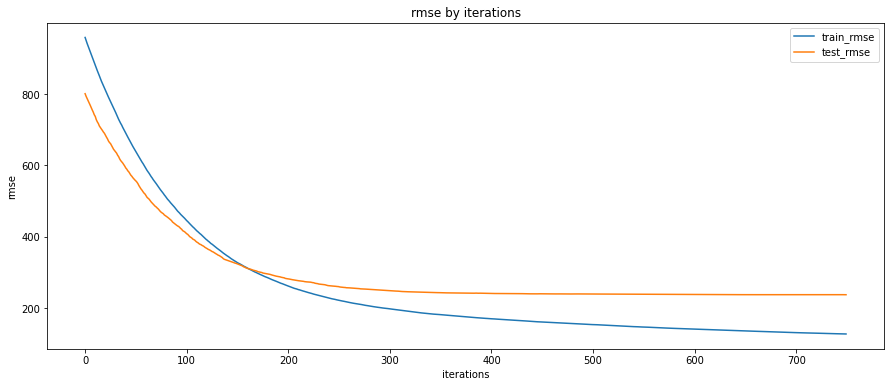

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
plot_validation(fit_mod.evals_result(), ax=ax)

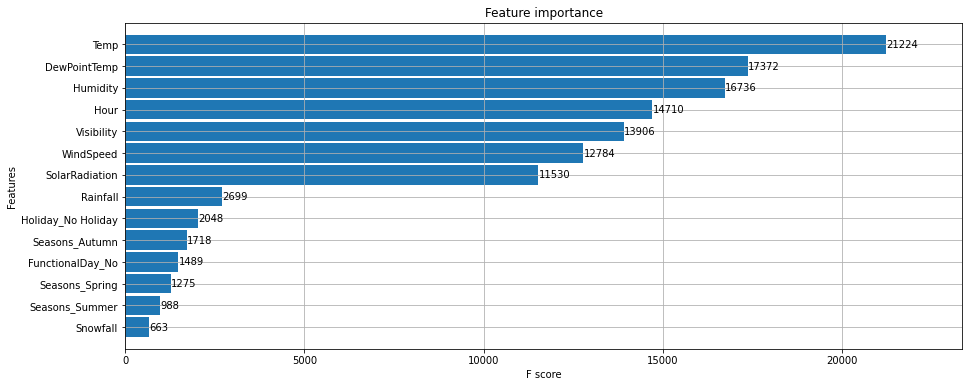

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
_ = xgb.plot_importance(fit_mod, height=0.9, ax=ax)

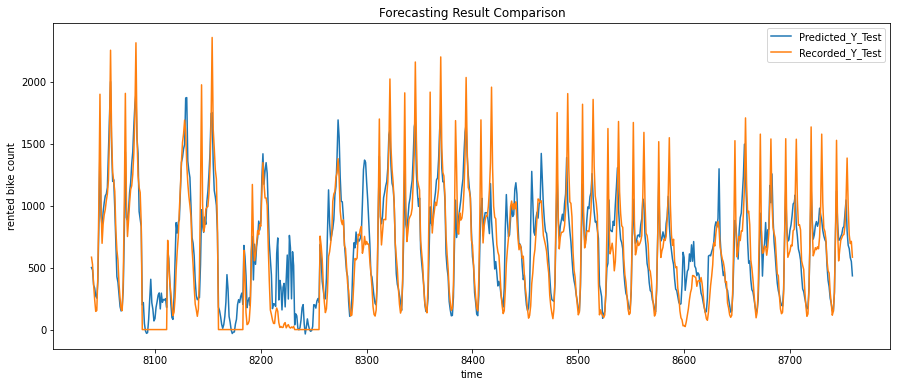

In [137]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
_=predict_df1.plot(xlabel="time", ylabel="rented bike count", 
                   title="Forecasting Result Comparison", ax=ax)

## Model Re-train with Data Update
### Model 2
* Anchor Date: 01/11/2018 to 29/11/2018
* Model training: daily

In [157]:
# define testing period
date_list = sorted(dat[dat['Date'].dt.month==11]['Date'].unique())

In [138]:
%%capture
# result collector
start_time = time.time()
res_sum2 = {'train_score': [], 'mean_cv_score': [], 'test_score': []}
predict_df2 = pd.DataFrame()

# start training for each day
for anchor_day in date_list:
    
    # generate train and test data
    train_df, test_df = split_by_time('', date_obj=anchor_day, hour=0)
    test_df = test_df.head(24)
    # print(f"Training {data_info(train_df)}. Date size {train_df.shape}.\nTraining {data_info(test_df)}. Date size {test_df.shape}.")
    
    train_x, train_y = prepare_x_y(train_df)
    test_x, test_y = prepare_x_y(test_df)
    
    # model training
    fit_mod, trained_grid = cv_xgb_train(train_x, train_y, test_x, test_y, False)
    
    # get results
    res_sum2['train_score'].append(fit_mod.score(train_x, train_y)) 
    res_sum2['mean_cv_score'].append(trained_grid.cv_results_['mean_test_score'].mean())
    res_sum2['test_score'].append(fit_mod.score(test_x, test_y))
    
    # predict values
    y_pred = fit_mod.predict(test_x)
    predict_df_sub = pd.DataFrame({"Predicted_Y_Test":y_pred, "Recorded_Y_Test": test_y})
    predict_df2 = predict_df2.append(predict_df_sub)

res_sum2['run_time'] = time.time() - start_time
res_sum2['test_r2'] = test_r2(y=predict_df2['Recorded_Y_Test'], yhat=predict_df2['Predicted_Y_Test'])

In [139]:
# print out result
printout_result(res_sum2)

train_score: avg  0.9600; std  0.0011
mean_cv_score: avg  0.6860; std  0.0110
test_score: avg -0.2191; std  3.8708
run_time:  1965.0154
test_r2:  0.7755


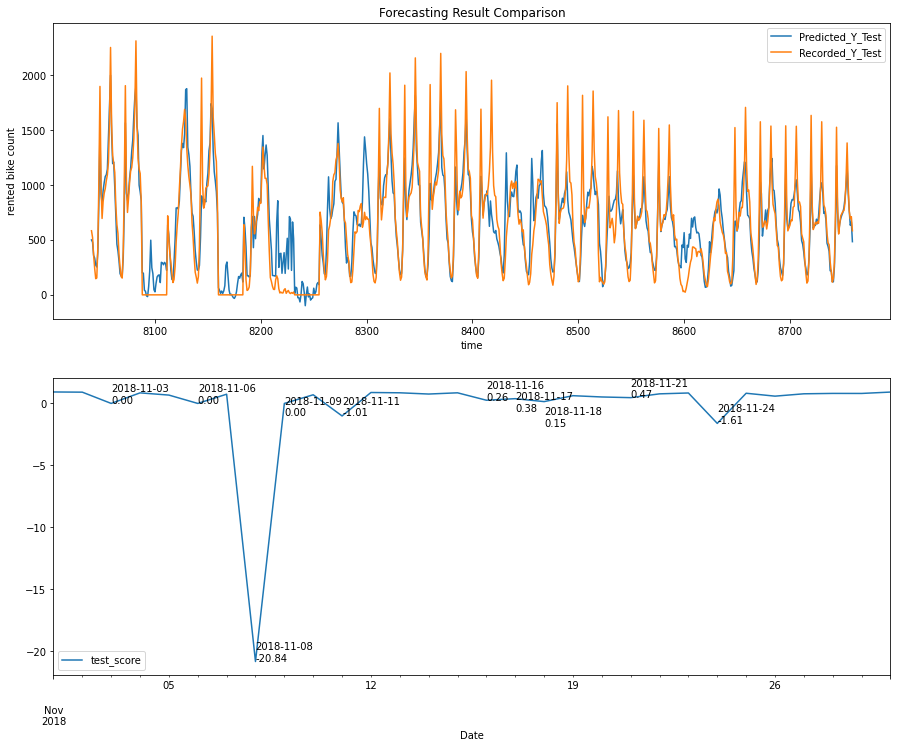

In [189]:
# Plot Outliers
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15,12))

_=predict_df2.plot(xlabel="time", ylabel="rented bike count", 
                   title="Forecasting Result Comparison", ax=ax[0])

outlier_cri = 0.5
outlier_df = pd.DataFrame({'Date': date_list, 'test_score': res_sum2['test_score']})
_=outlier_df.plot(x='Date', y='test_score', ax=ax[1])
prev_text = 0
for index, row in outlier_df.iterrows():
    date = row['Date']
    test_score = row['test_score']
    if test_score < outlier_cri:
        y_loc = test_score-prev_text
        plt.text(date, y_loc, f"{str(pd.to_datetime(date).date())}\n{test_score:.2f}")
        prev_text += 1
    else:
        prev_text = 0

### Model 3
* Anchor Date: 01/11/2018 to 29/11/2018
* Model training: hourly

In [192]:
# define testing period
hour_list = list(range(24))

In [201]:
%%capture
# result collector
start_time = time.time()
res_sum3 = {'train_score': [], 'mean_cv_score': [], 'test_score': []}
predict_df3 = pd.DataFrame()

# start training for each day
for anchor_day in date_list:
    for hour in hour_list:
    
        # generate train and test data
        train_df, test_df = split_by_time('', date_obj=anchor_day, hour=hour)
        test_df = test_df.head(1)
        # print(f"Training {data_info(train_df)}. Date size {train_df.shape}.\nTraining {data_info(test_df)}. Date size {test_df.shape}.")
    
        train_x, train_y = prepare_x_y(train_df)
        test_x, test_y = prepare_x_y(test_df)
    
        # model training
        fit_mod, trained_grid = cv_xgb_train(train_x, train_y, test_x, test_y, False)
    
        # get results
        res_sum3['train_score'].append(fit_mod.score(train_x, train_y)) 
        res_sum3['mean_cv_score'].append(trained_grid.cv_results_['mean_test_score'].mean())
        res_sum3['test_score'].append(fit_mod.score(test_x, test_y))
    
        # predict values
        y_pred = fit_mod.predict(test_x)
        predict_df_sub = pd.DataFrame({"Predicted_Y_Test":y_pred, "Recorded_Y_Test": test_y})
        predict_df3 = predict_df3.append(predict_df_sub)

res_sum3['run_time'] = time.time() - start_time
res_sum3['test_r2'] = test_r2(y=predict_df3['Recorded_Y_Test'], yhat=predict_df3['Predicted_Y_Test'])

In [202]:
# save prediction result
import json
output_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), './data/'))
predict_df3.to_csv(os.path.join(output_dir, "output_mod3_predict.csv"), index=True)
with open(os.path.join(output_dir, "output_mod3_summary.json"), 'w') as fp:
    json.dump(res_sum3, fp)

In [203]:
# print out result
printout_result(res_sum3)

train_score: avg  0.9598; std  0.0029
mean_cv_score: avg  0.6859; std  0.0112
test_score: avg  nan; std  nan
run_time:  54192.1479
test_r2:  0.8171


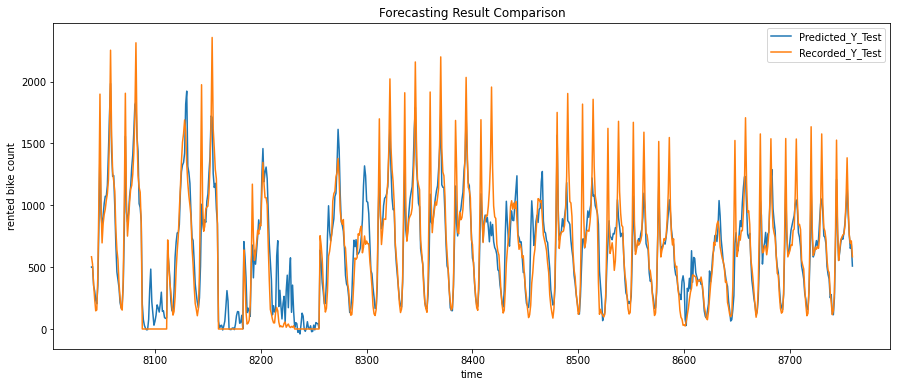

In [207]:
# Plot Forecasting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
_=predict_df3.plot(xlabel="time", ylabel="rented bike count", 
                   title="Forecasting Result Comparison", ax=ax)

# Model Result Comparison

In [204]:
res_list = [res_sum1, res_sum2, res_sum3]
res_com_df = None
for idx, res_sum in enumerate(res_list):
    if res_com_df is None:
        res_com_df = pd.DataFrame(index=list(res_sum.keys()))
    res_com_df[f"Mod_{idx+1}"] = [np.mean(v) if isinstance(v, list) else v for v in res_sum.values()]
res_com_df

,Mod_1,Mod_2,Mod_3
train_score,0.962043,0.960037,0.959825
mean_cv_score,0.680463,0.686041,0.685879
test_score,0.757189,-0.219109,NaN
run_time,52.709315,1965.015350,54192.147896
test_r2,0.757189,0.775499,0.817051


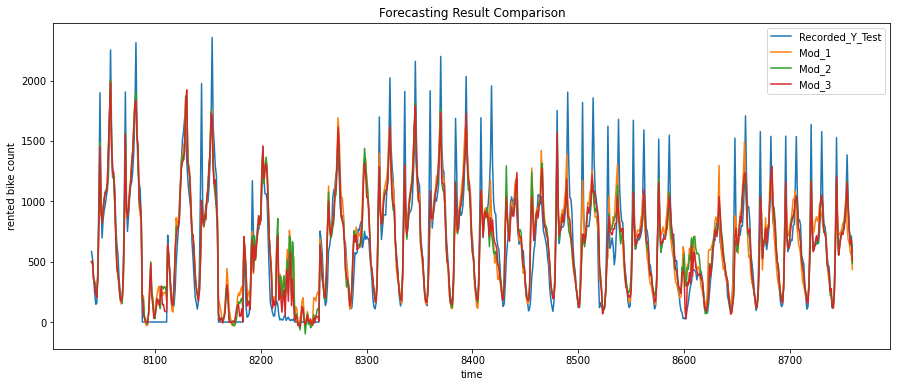

In [205]:
pred_list = [predict_df1, predict_df2, predict_df3]
pred_com_df = None
for idx, pred_df in enumerate(pred_list):
    if pred_com_df is None:
        pred_com_df = pd.DataFrame({'Recorded_Y_Test':pred_df['Recorded_Y_Test'],
                                   f"Mod_{idx+1}": pred_df['Predicted_Y_Test']})
    else:
        pred_com_df[f"Mod_{idx+1}"] = pred_df['Predicted_Y_Test']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
_=pred_com_df.plot(xlabel="time", ylabel="rented bike count", title="Forecasting Result Comparison", ax=ax)